# Diyabet Sonuçları Üzerinde Tahmin Modellerinin Karşılaştırılması

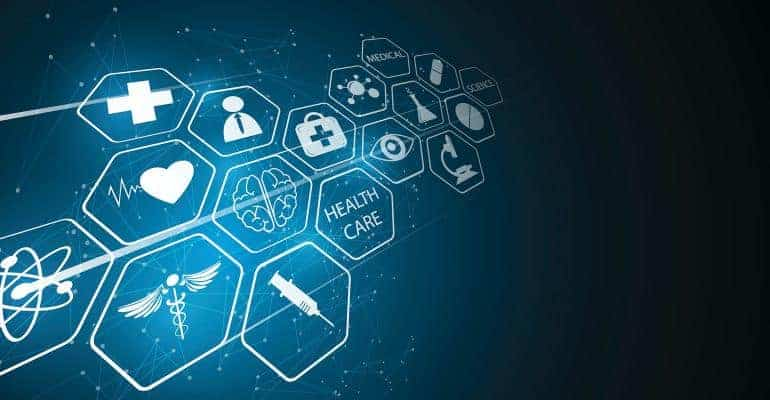

# Proje Konusu

Bu veriseti, vücutları hakkında tıbbi ayrıntılar verilen 21 yaşın üzerindeki Pima Indian mirasına sahip kadınlarda beş yıl içinde diyabetin başlangıcını tahmin etmek için kullanılır. Veri setinin, ikili sınıflandırma (2 sınıflı) makine öğrenimi problemine karşılık gelmesi amaçlanmıştır.

Diyabet hastası olma durumunu gösteren bağımlı bir değişkenimiz var. Amacımız, diyabet durumunu gösteren değişken ile diğer değişkenler arasındaki ilişkiyi modellemektir.

Kişilerin çeşitli özellikleri girildiğinde, bu kişilerin şeker hastası olup olmayacağına dair tahmin yapacak bir makine öğrenimi modeli oluşturmak istiyoruz. Bu bir sınıflandırma problemidir.

## Veri Seti Bilgileri

Bu veriseti orijinal olarak National Institute of Diabetes and Digestive and Kidney Diseases'den alınmıştır. Veri setinin amacı, bir hastanın diyabetli olup olmadığını, veri setine dahil edilen belirli tanısal ölçümlere dayalı olarak tahmin etmektir. Bu örneklerin daha büyük bir veritabanından seçilmesiyle ilgili çeşitli kısıtlamalar getirildi. Özellikle buradaki tüm hastalar, Pima Indian mirasından en az 21 yaşında olan kadınlardır.

9 sütunumuz ve 768 örneğimiz (satırımız) var. Sütun adları aşağıdaki şekilde verilmiştir:

    - Pregnancies: Hamile sayısı
    - Glucose: Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu
    - BloodPressure: Diyastolik kan basıncı (mm Hg)
    - SkinThickness: Triceps deri kıvrım kalınlığı (mm)
    - Insulin: 2 saatlik serum insülin ölçümü (mu U/ml)
    - BMI: Vücut kitle indeksi (kg cinsinden ağırlık / (m cinsinden yükseklik) 2)
    - DiabetesPedigreeFunction: Diyabet soyağacı fonksiyonu
    - Age: Yaş (yıl)
    - Outcome: Sınıf değişkeni (0 veya 1, 0 = diyabetik değil, 1 = diyabetik)

# Veriyi Anlama

In [ ]:
#kütüphanelerin kurulumu
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

In [ ]:
#projeyi önemli ölçüde etkilemeyen tüm uyarılar göz ardı edilir
import warnings
warnings.simplefilter(action = "ignore") 

In [ ]:
#veri setini okuma
df = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")
#ilk 5 gözlemin seçimi
df.head() 

In [ ]:
#bir nesnenin ekseninden rastgele olacak şekilde öğeleri getirir
df.sample(3) 

In [ ]:
#veri setinden yazılı değer oranında rastgele seçim yapar
df.sample(frac = 0.01) 

In [ ]:
#boyut bilgisi
df.shape

In [ ]:
#dataframe'in indeks dtype ve sütun dtypes, boş olmayan değerler ve bellek kullanım bilgileri
df.info()

In [ ]:
#belirtilen yüzdelere karşılık gelen gözlem birimlerinin açıklayıcı istatistik değerleri
df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T
#değerlendirmeyi kolaylaştırması amacıyla df tablosunun transpozu alındı.

In [ ]:
#değişkenler arasındaki korelasyon
df.corr()

Nihai hedefimiz, diyabetin başlangıcını tahmin etmek için verilerimizdeki kalıplardan yararlanmaktır. Aşağıda diyabet geliştirenler ile geliştirmeyenler arasındaki bazı farklılıkların görselleştirilme uygulamaları verilmiştir

In [ ]:
#Glucose sütununun her iki sınıf özelinde histogramının alınması

col = 'Glucose'
plt.hist(df[df['Outcome']==0][col], 10, alpha=0.5, label='non-diabetes')
plt.hist(df[df['Outcome']==1][col], 10, alpha=0.5, label='diabetes')
plt.legend(loc='upper right')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(col))
plt.show()

Bu histogram bize Glikoz ve iki tahmin sınıfı arasında oldukça büyük bir fark gösteriyor.

In [ ]:
for col in ['BMI', 'BloodPressure']:
    plt.hist(df[df['Outcome']==0][col], 10, alpha=0.5, label='non-diabetes')
    plt.hist(df[df['Outcome']==1][col], 10, alpha=0.5, label='diabetes')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()

Bu histogramlar bize iki sınıf değişkeni (diyabet olan ve diyabet olmayan) için 'BMI', 'BloodPressure', 'Glucose' dağılımlarını gösterir.

Diyabet geliştirecek olanlar için 'Glucose'da büyük bir artış var gibi görünüyor. Bunu sağlamlaştırmak için, bu değişkenler arasındaki ilişkiyi ölçmek amacıyla korelasyon matrisini görselleştirebiliriz.

In [ ]:
def plot_corr(df,size = 9): 
    corr = df.corr() #corr = değişken, korelasyon matrisini bir değişkene atadığımız yer
    fig, ax = plt.subplots(figsize = (size,size)) 
    #fig = grafiğin sağındaki sütun, subplots (figsize = (size, size)) = grafiğin boyutunu belirler of the chart
    ax.matshow(corr) #doğrudan matshow matrisini çizen korelasyonu yazdırır
    cax=ax.matshow(corr, interpolation = 'nearest') #ekseni çizdirme, grafiği kare veya harita gibi yapan kod
    fig.colorbar(cax) #rengi çizdirme
    plt.xticks(range(len(corr.columns)),corr.columns,rotation=65) 
    #xticks çizdirir, rotation = 17 her bir üst sütun için yazılan ifadelerin eğimli yazdırılması içindir
    plt.yticks(range(len(corr.columns)),corr.columns) #yticks çizdirir

In [ ]:
#dataframe'i fonksiyonu kullanarak çizeriz
plot_corr(df) 

In [ ]:
#seaborn kütüphanesindeki korelasyon matrisi
import seaborn as sb
sb.heatmap(df.corr());

In [ ]:
#bu şekilde korelasyonları görebiliriz
sb.heatmap(df.corr(),annot =True); 

Sonuç: Outcome ile en yüksek korelasyon Glucose, BMI, Age and Pregnancies arasında gözlendi.

In [ ]:
# Outcome değişkeninde 0 ve 1 sınıflarının oranları
df["Outcome"].value_counts()*100/len(df)

In [ ]:
#kaç sınıf 0 ve 1'dir
df.Outcome.value_counts()

In [ ]:
#Age değişkeninin histogramı
df["Age"].hist(edgecolor = "black");

In [ ]:
#Age, Glucose and BMI değişkenlerinin Outcome değişkenine göre ortalamaları
df.groupby("Outcome").agg({"Age":"mean","Glucose":"mean","BMI":"mean"})

# Veri Ön İşleme

## Eksik Veri Analizi

In [ ]:
#veri setinde eksik veri yok
df.isnull().sum()

In [ ]:
#aşağıdaki değişkenlerdeki sıfırlar NA anlamına gelir, bu nedenle NA yerine 0 atanır
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

Veri setinde eksik bir değer yokmuş gibi görünmektedir, ancak değişkenler incelendiğinde bu değişkenlerdeki sıfırlar NA anlamına geldiği tespit edilmiştir.

In [ ]:
#özel değerler
df.isnull().sum()

In [ ]:
def median_target(var):   
    
    temp = df[df[var].notnull()] 
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index() #reset_index; indekslerdeki problemler çözüldü
    
    return temp
#boş olmayanlar, df içinden seçilir ve doldurulan gözlem birimleri göz ardı edilerek temp adlı bir dataframe'e atanır.

Dataframe'den seçilen bağımsız ve bağımlı değişken üzerinde işlemler yapıldı. Bağımlı değişkene gruplama işlemi uygulandı ardından bağımsız değişken seçildi ve bu değişkenin medyanı alındı.

In [ ]:
#Outcome değerinin 0 ve 1 değerine göre alınan Glucose'un medyan değeri
median_target("Glucose")

In [ ]:
#eksik gözlemler için diyabet olan ve diyabet olamayanların medyan değerleri 
columns = df.columns

columns = columns.drop("Outcome")

for col in columns:
    
    df.loc[(df['Outcome'] == 0 ) & (df[col].isnull()), col] = median_target(col)[col][0]
    df.loc[(df['Outcome'] == 1 ) & (df[col].isnull()), col] = median_target(col)[col][1]
    #Outcome değeri 0'ı ve ilgili boş değişkeni seçin, ilgili değişkeni seçin, aynı işlem 1 içinde yapıldı
#virgül öncesi filtreleme işlemlerini ifade eder, virgülden sonra sütun seçimi için kullanılır.

## Feature Engineering

In [ ]:
#BMI değişkenine göre bazı aralıklar belirlenmiş ve kategorik değişkenler atanmıştır.
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

df["NewBMI"] = NewBMI

df.loc[df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]

df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

In [ ]:
df.head()

In [ ]:
#insülin değerine göre kategorik değişken oluşturma
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"     

In [ ]:
df.head()

In [ ]:
#NewInsulinScore değişkeni set_insulin ile eklendi
df["NewInsulinScore"] = df.apply(set_insulin, axis=1)

In [ ]:
df.head()

In [ ]:
#Glucose değişkenine göre bazı aralıklar belirlenmiş ve bunlara kategorik değişkenler atanmıştır
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")

df["NewGlucose"] = NewGlucose

df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]

df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]

df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]

df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [ ]:
df.head()

## One-Hot Encoding

In [ ]:
#categorical değişkenler, One Hot Encoding dönüşümü yapılarak sayısal değerlere dönüştürüldü
#bu işlem ayrıca Dummy değişken tuzağından da korur
df = pd.get_dummies(df, columns =["NewBMI","NewInsulinScore", "NewGlucose"], drop_first = True)

In [ ]:
df.head()

## Değişken Standardizasyonu

In [ ]:
#kategorik değişkenler
categorical_df = df[['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

In [ ]:
#categorical değişkenler df'den silindi
y = df["Outcome"]
X = df.drop(["Outcome",'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'], axis = 1)
cols = X.columns
index = X.index

In [ ]:
y.head()

In [ ]:
X.head()

In [ ]:
#veri setindeki değişkenler standartlaştırılarak modellerin performansı artırılır
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

In [ ]:
X.head()

In [ ]:
#kategorik olan ve kategorik olmayan değişkenleri birleştirme
X = pd.concat([X, categorical_df], axis = 1)

In [ ]:
X.head()

# Modelleme

In [ ]:
models = []
models.append(('LR', LogisticRegression(random_state = 12345)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state = 12345)))
models.append(('RF', RandomForestClassifier(random_state = 12345)))
models.append(('SVM', SVC(gamma='auto', random_state = 12345)))
models.append(('XGB', GradientBoostingClassifier(random_state = 12345)))
models.append(("LightGBM", LGBMClassifier(random_state = 12345)))

#sırasıyla her modeli değerlendirme
results = []
names = []

for name, model in models:
        
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
#boxplot ile algoritmaların karşılaştırması
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results,
            vert=True, #dikey kutu hizalaması
            patch_artist=True) #renkle doldur
                         
ax.set_xticklabels(names)
plt.show()

RF, XGB ve LightGBM diğer modellere göre daha iyi sonuçlar vermesinden dolayı bu modellerin optimize edilmesine odaklanılmıştır.

# Model Optimizasyonu

## Model Tuning

### Random Forests Tuning

In [ ]:
rf_params = {"n_estimators" :[100,200,500,1000], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
            "max_depth": [3,5,8,None]}

In [ ]:
rf_model = RandomForestClassifier(random_state = 12345)

In [ ]:
gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = 10,
                    n_jobs = -1,
                    verbose = 2).fit(X, y)

In [ ]:
gs_cv.best_params_

### Final Modelin Kurulumu

In [ ]:
rf_tuned = RandomForestClassifier(**gs_cv.best_params_)

In [ ]:
rf_tuned = rf_tuned.fit(X,y)

In [ ]:
cross_val_score(rf_tuned, X, y, cv = 10).mean()

In [ ]:
feature_imp = pd.Series(rf_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index, palette="Blues_d")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Severity Levels")
plt.show()

### XGBoost Tuning

In [ ]:
xgb = GradientBoostingClassifier(random_state = 12345)

In [ ]:
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 3),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators": [100,500]}

In [ ]:
xgb_cv = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X, y)

In [ ]:
xgb_cv.best_params_

### Final Modelin Kurulumu

In [ ]:
xgb_tuned = GradientBoostingClassifier(**xgb_cv.best_params_).fit(X,y)

In [ ]:
cross_val_score(xgb_tuned, X, y, cv = 10).mean()

In [ ]:
feature_imp = pd.Series(xgb_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index, palette="Blues_d")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Severity Levels")
plt.show()

### LightGBM Tuning

In [ ]:
lgbm = LGBMClassifier(random_state = 12345)

In [ ]:
lgbm_params = {"learning_rate": [0.01, 0.03, 0.05, 0.1, 0.5],
              "n_estimators": [500, 1000, 1500],
              "max_depth":[3,5,8]}

In [ ]:
gs_cv = GridSearchCV(lgbm, 
                     lgbm_params, 
                     cv = 10, 
                     n_jobs = -1, 
                     verbose = 2).fit(X, y)

In [ ]:
gs_cv.best_params_

### Final Modelin Kurulumu

In [ ]:
lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X,y)

In [ ]:
cross_val_score(lgbm_tuned, X, y, cv = 10).mean()

In [ ]:
feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index, palette="Blues_d")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Severity Levels")
plt.show()

# Final Modellerinin Karşılaştırılması

In [ ]:
models = []

models.append(('RF', RandomForestClassifier(random_state = 12345, max_depth = 8, max_features = 7, min_samples_split = 2, n_estimators = 500)))
models.append(('XGB', GradientBoostingClassifier(random_state = 12345, learning_rate = 0.1, max_depth = 5, min_samples_split = 0.1, n_estimators = 100, subsample = 1.0)))
models.append(("LightGBM", LGBMClassifier(random_state = 12345, learning_rate = 0.01,  max_depth = 3, n_estimators = 1000)))

results = []
names = []

Model tuning işlemleri ile base modellere göre daha iyi tahminler yapılmıştır.

In [ ]:
for name, model in models:
    
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
#boxplot ile algoritmaların karşılaştırması
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results,
            vert=True, #dikey kutu hizalaması
            patch_artist=True) #renkle doldur
                         
ax.set_xticklabels(names)
plt.show()

# Sonuç    
     
 - Farklı özelliklere sahip 21 yaşın üzerindeki Pima Indian mirasına sahip kadınların insanların diyabet hastası olup olmayacağını tahmin etmek için makine öğrenimi modelleri oluşturuldu.
    
    
 - Veri setini en iyi tanımlayan 3 sınıflandırma modeli seçildi ve bu modeller başarı oranlarına göre karşılaştırıldı. Karşılaştırılan modeller Random Forests, XGBoost, LightGBM'dir.


 - Kurulan modellerin kıyaslanması sonucunda; bu veri seti özelinde veriyi en iyi açıklayan ve en iyi sonuçları veren modelin LightGBM olduğu belirlenmiştir.

# Kaynaklar

    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
    
    - https://www.udemy.com/course/python-egitimi/
    
    - https://github.com/omarozt/MachineLearningWorkshop
    
    - https://www.kaggle.com/ibrahimyildiz/pima-indians-diabetes-pred-0-9078-acc
    
    - https://seaborn.pydata.org/examples/color_palettes.html
    
    - https://seaborn.pydata.org/examples/color_palettes.html 
    
    - https://www.jonobacon.com/2017/08/06/joining-data-world-advisory-board/

    - https://towardsdatascience.com/data-preprocessing-concepts-fa946d11c825
    
    - https://becominghuman.ai/data-preprocessing-a-basic-guideline-c0842b7883fa
        
    - Feature Engineering Made Easy, Sinan Ozdemir and Divya Susarla 